# Analysis on delirium patients from MIMIC III database

1. This notebook contains all the images generated from the dataset, that are included in the article submitted.
2. The notebook is divided into: data preprocessing, figures, Linear regression and Logistic regression.
3. The csv file is not added since the sql file to generate delirium patients data from MIMIC III database is still under development. However, we can view how the dataset looks like by looking at it's dimensions, column names, and sample data from the table.
4. Race distribution is not added, since that requires a more in-depth analysis in other direction.

# Data preprocessing

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [3]:
def read_from_db(sql):
    conn = psycopg2.connect(database = "mimic", user = "postgres", password = "riddhi", host = "127.0.0.1", port = "5432")
    data = pd.read_sql(sql, con=conn)
    conn.close()
    return data

In [4]:
def label_drug_group(row):
    if "Haloperidol" in row['drugs']:
        return 1
    if "No drug" in row['drugs']:
        return 2
    if "Haloperidol" not in row['drugs'] and "No drug" not in row['drugs']:
        return 3
    return 0

In [5]:
sql = "SELECT * FROM public.delirium_table_3"
data = read_from_db(sql)
data['drug_group'] = data.apply(lambda row: label_drug_group(row), axis=1)

In [6]:
data.shape

(1671, 23)

In [7]:
data.columns

Index(['subject_id', 'gender', 'age', 'ethnicity', 'hadm_id', 'icustay_id',
       'los_days', 'icd9_codes', 'drugs', 'dist_cat_count', 'drug_catagories',
       'cat_surgery', 'cat_pneu', 'sepsis', 'dementia', 'alzheimers',
       'depression', 'anxiety', 'death_hosp', 'death_one_year', 'mechvent',
       'mechvent_duration_hours', 'drug_group'],
      dtype='object')

In [8]:
data.sample(5)

,subject_id,gender,age,ethnicity,hadm_id,icustay_id,los_days,icd9_codes,drugs,dist_cat_count,...,sepsis,dementia,alzheimers,depression,anxiety,death_hosp,death_one_year,mechvent,mechvent_duration_hours,drug_group
562,27425,M,62.06,WHITE,137253,251790.0,14.0223,4271: Parox ventric tachycard\n03849: Gram-neg...,Quetiapine Fumarate\nOlanzapine (Disintegratin...,4,...,1,0,0,0,0,0,0,2,"11.75, 141.25",1
564,27530,M,64.41,WHITE,129816,201501.0,6.1660,V5049: Prphylct orgn rmvl other\nV420: Kidney ...,Quetiapine Fumarate,1,...,0,0,0,0,0,0,0,0,,3
1424,83149,F,84.15,WHITE,176022,248326.0,0.5804,82021: Intertrochanteric fx-cl\n2851: Ac posth...,Quetiapine Fumarate\nHaloperidol\nHaloperidol\...,3,...,0,0,0,0,0,0,0,0,,1
1461,85407,F,72.83,UNKNOWN/NOT SPECIFIED,129707,214843.0,1.1170,0389: Septicemia NOS\n41519: Pulm embol/infarc...,No drug,0,...,0,0,0,0,0,1,1,0,,2
977,54523,M,84.08,WHITE,106421,275893.0,31.2165,99731: Ventltr assoc pneumonia\n5845: Ac kidny...,Quetiapine Fumarate\nHaloperidol\nHaloperidol\...,3,...,0,0,0,0,0,0,0,3,"405, 124, 11",1


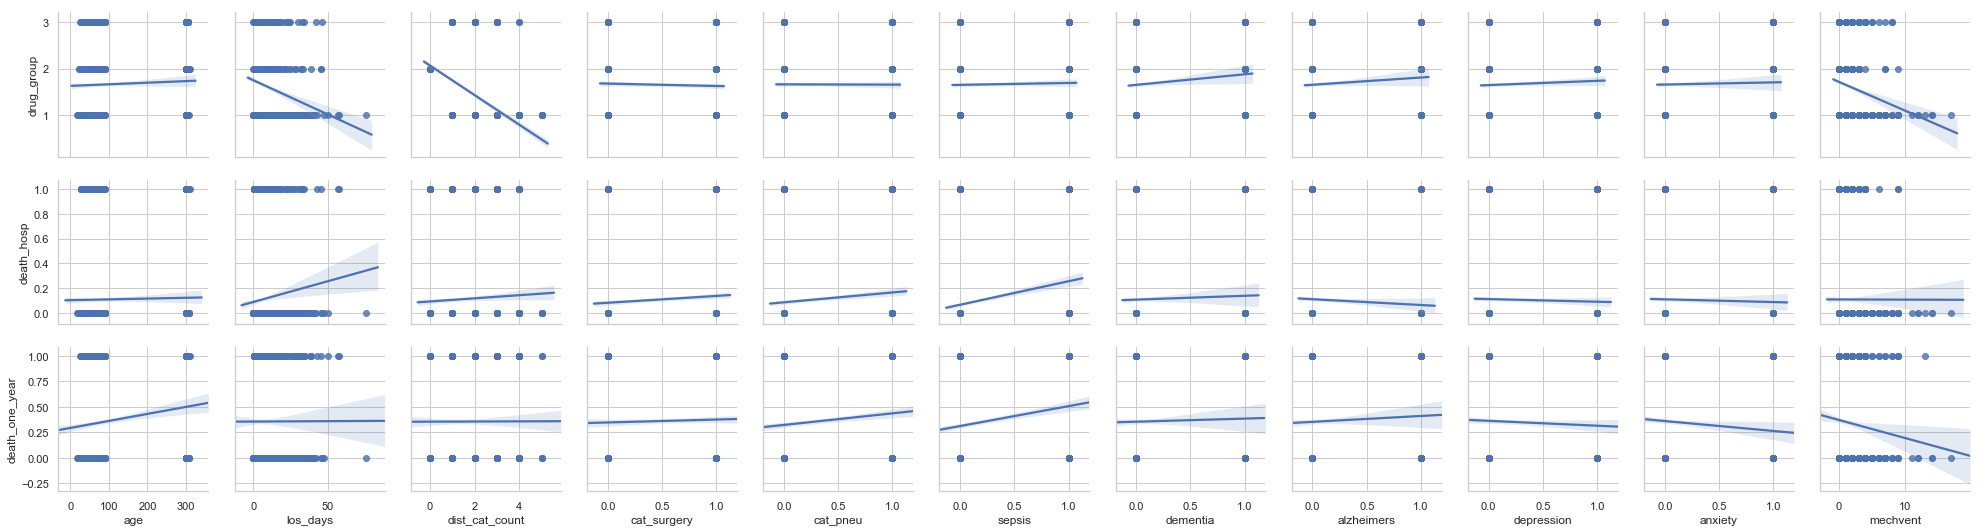

In [9]:
sns.pairplot(data, x_vars=['age', 'los_days', 'dist_cat_count', 'cat_surgery', 'cat_pneu', 'sepsis', 'dementia', 'alzheimers', 'depression', 'anxiety', 'mechvent'], y_vars=['drug_group', 'death_hosp', 'death_one_year'], kind='reg')


---

# Figure 1: Counts of different type of delirium patients

In [10]:
sql = " \
SELECT COUNT(d_icd.subject_id) AS count_diagnoses, d_icd.icd9_code, \
    d_icd_diag.short_title, d_icd_diag.long_title \
FROM mimiciii.diagnoses_icd d_icd, mimiciii.d_icd_diagnoses d_icd_diag \
WHERE d_icd.icd9_code = d_icd_diag.icd9_code \
    AND d_icd.icd9_code IN \
    (SELECT icd9_code FROM mimiciii.d_icd_diagnoses \
    WHERE LOWER(long_title) LIKE '%delirium%' OR LOWER(short_title) LIKE '%delirium%') \
GROUP BY d_icd.icd9_code, d_icd_diag.short_title, d_icd_diag.long_title \
ORDER BY d_icd.icd9_code;"

data_delirium = read_from_db(sql)

data_delirium['percentage'] = (data_delirium.count_diagnoses * 100) / data_delirium.count_diagnoses.sum()

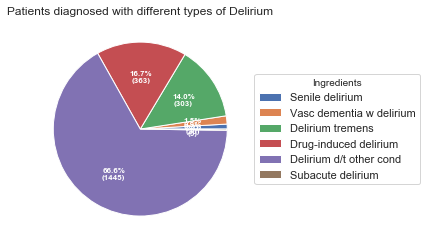

In [11]:
fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(aspect="equal"))

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data_delirium.count_diagnoses, autopct=lambda pct: func(pct, data_delirium.count_diagnoses), textprops=dict(color="w"))

ax.legend(wedges, data_delirium.short_title, title="Ingredients", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Patients diagnosed with different types of Delirium")

plt.show()

---

# Figure 2: Delirium patienst with different drug group

In [12]:
halo_group = data[data['drugs'].str.contains("Haloperidol")]
no_drug_group = data[data['drugs'].str.contains("No drug")]
other_drug_group = data[~data['drugs'].str.contains("Haloperidol") & ~data['drugs'].str.contains("No drug")]

counts = {'title': ['Count of patients given Haloperidol', 'Count of patients given No drugs', 'Count of patients given Other drugs'], 
          'count': [halo_group.shape[0], no_drug_group.shape[0], other_drug_group.shape[0]]}
index = [0, 1, 2]
count_data = pd.DataFrame(counts, index=index)

count_data['percentage'] = (count_data['count'] * 100) / count_data['count'].sum()

count_data

,title,count,percentage
0,Count of patients given Haloperidol,889,53.201676
1,Count of patients given No drugs,462,27.648115
2,Count of patients given Other drugs,320,19.150209


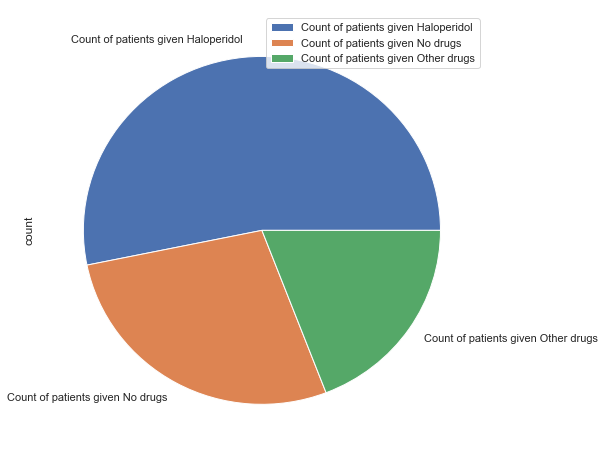

In [13]:
count_data = count_data.set_index(['title'])
count_data.plot.pie(y='count', figsize=(8, 8))

---

# Figure 3: Distinct drug type count in different drug groups

In [14]:
count_0 = data[data['dist_cat_count'] == 0].shape[0]
count_1 = data[data['dist_cat_count'] == 1].shape[0]
count_2 = data[data['dist_cat_count'] == 2].shape[0]
count_3 = data[data['dist_cat_count'] == 3].shape[0]
count_4 = data[data['dist_cat_count'] == 4].shape[0]
count_5 = data[data['dist_cat_count'] == 5].shape[0]

count_0_halo = data[(data['dist_cat_count'] == 0) & (data['drugs'].str.contains("Haloperidol"))].shape[0]
count_1_halo = data[(data['dist_cat_count'] == 1) & (data['drugs'].str.contains("Haloperidol"))].shape[0]
count_2_halo = data[(data['dist_cat_count'] == 2) & (data['drugs'].str.contains("Haloperidol"))].shape[0]
count_3_halo = data[(data['dist_cat_count'] == 3) & (data['drugs'].str.contains("Haloperidol"))].shape[0]
count_4_halo = data[(data['dist_cat_count'] == 4) & (data['drugs'].str.contains("Haloperidol"))].shape[0]
count_5_halo = data[(data['dist_cat_count'] == 5) & (data['drugs'].str.contains("Haloperidol"))].shape[0]

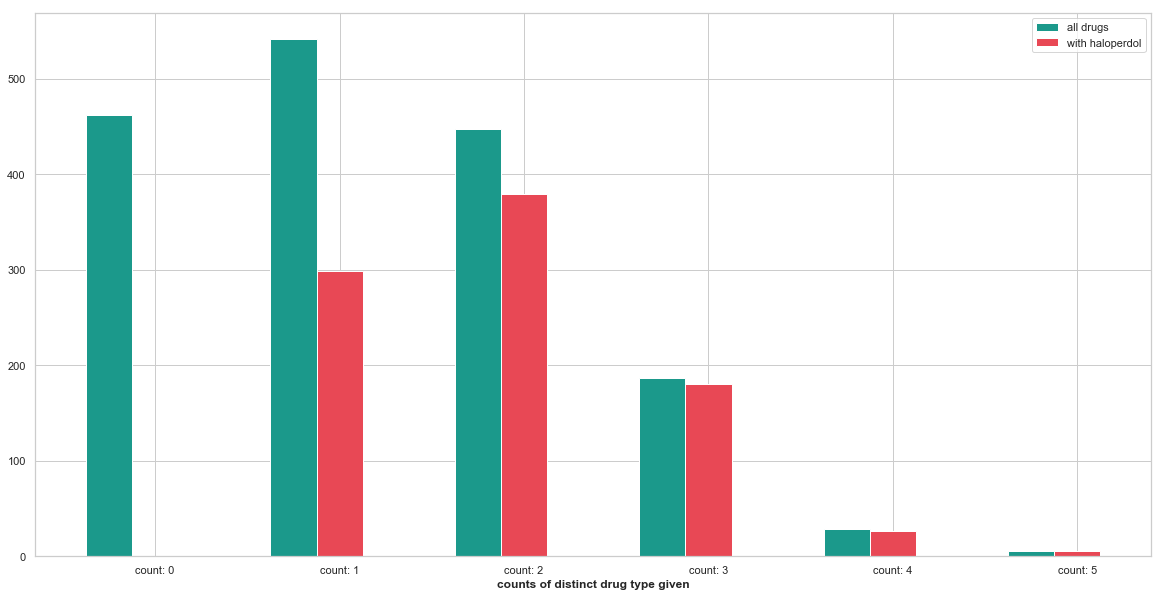

In [15]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [count_0, count_1, count_2, count_3, count_4, count_5]
bars2 = [count_0_halo, count_1_halo, count_2_halo, count_3_halo, count_4_halo, count_5_halo]

plt.figure(figsize=(20,10))
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#1B998B', width=barWidth, edgecolor='white', label='all drugs')
plt.bar(r2, bars2, color='#E84855', width=barWidth, edgecolor='white', label='with haloperdol')
 
# Add xticks on the middle of the group bars
plt.xlabel('counts of distinct drug type given', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['count: 0', 'count: 1', 'count: 2', 'count: 3', 'count: 4', 'count: 5'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

---

# Figure 4: Age distribution

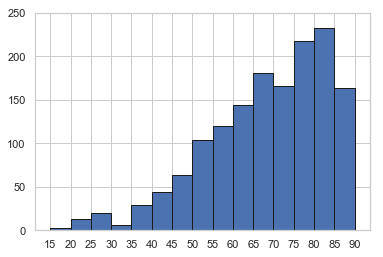

In [16]:
bins = [x*5+15 for x in range(0, 16)] # results in 15, 20, ... 85, 90
plt.hist(data['age'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.ylim(0, 250)
plt.show()

---

# Figure 5: Sex distribution

In [17]:
male_group = data[data['gender'] == 'M']
female_group = data[data['gender'] == 'F']

male_halo_group = halo_group[halo_group['gender'] == 'M']
female_halo_group = halo_group[halo_group['gender'] == 'F']

male_no_drug_group = no_drug_group[no_drug_group['gender'] == 'M']
female_no_drug_group = no_drug_group[no_drug_group['gender'] == 'F']

male_other_drug_group = other_drug_group[other_drug_group['gender'] == 'M']
female_other_drug_group = other_drug_group[other_drug_group['gender'] == 'F']

gender_data = pd.DataFrame({'male': [male_group.shape[0], male_halo_group.shape[0], male_no_drug_group.shape[0], male_other_drug_group.shape[0]],
 'female': [female_group.shape[0], female_halo_group.shape[0], female_no_drug_group.shape[0], female_other_drug_group.shape[0]],
 'group': ['all_drugs', 'haloperidol', 'no_drugs', 'other_drugs']})

gender_data = gender_data.set_index(['group'])

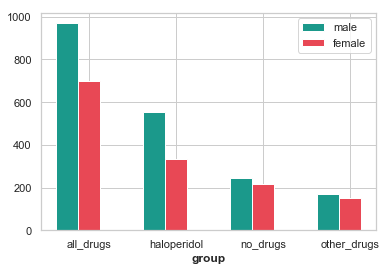

In [18]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [male_group.shape[0], male_halo_group.shape[0], male_no_drug_group.shape[0], male_other_drug_group.shape[0]]
bars2 = [female_group.shape[0], female_halo_group.shape[0], female_no_drug_group.shape[0], female_other_drug_group.shape[0]]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color='#1B998B', width=barWidth, edgecolor='white', label='male')
plt.bar(r2, bars2, color='#E84855', width=barWidth, edgecolor='white', label='female')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['all_drugs', 'haloperidol', 'no_drugs', 'other_drugs'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

---

# Figure 6: Length-of-stay distribution

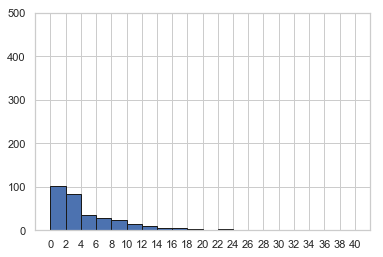

In [19]:
bins = [x*2 for x in range(0, 21)] # results in 0, 2, ... 38, 40
plt.hist(data[~data['drugs'].str.contains("Haloperidol") & ~data['drugs'].str.contains("No drug")]['los_days'], bins=bins, edgecolor="k")
plt.xticks(bins)
plt.ylim(0, 500)
plt.show()

# Linear Regression

In [20]:
feature_cols = ['age', 'los_days', 'dist_cat_count', 'cat_surgery', 'cat_pneu', 'sepsis', 'dementia', 'alzheimers', 'depression', 'anxiety', 'mechvent']
label_cols = ['drug_group', 'death_hosp', 'death_one_year']

X = data[feature_cols]
Y = data[label_cols]

In [21]:
X = X.fillna(0)

In [22]:
X.sample(10)

,age,los_days,dist_cat_count,cat_surgery,cat_pneu,sepsis,dementia,alzheimers,depression,anxiety,mechvent
510,80.25,7.7780,0,1.0,1,1,0,0,0,0,0
1260,69.25,1.1795,1,0.0,0,0,0,0,0,0,0
500,300.00,3.2477,2,0.0,1,0,0,0,0,0,1
516,66.83,7.5921,2,1.0,1,0,0,0,0,0,1
349,66.04,1.9195,2,1.0,0,0,0,0,0,0,0
1234,73.96,2.0519,2,1.0,0,0,0,0,0,0,1
1615,69.30,1.7039,1,1.0,0,0,0,0,0,0,0
1132,85.20,4.3460,2,0.0,0,0,0,0,0,0,1
1516,72.62,1.3950,3,1.0,0,1,0,0,0,0,0
571,42.40,3.0550,0,0.0,0,0,0,0,0,0,0


In [23]:
Y.sample(10)

,drug_group,death_hosp,death_one_year
1118,2,0,1
1264,1,0,0
1229,1,0,0
670,1,0,1
1595,2,0,0
1267,1,0,0
633,3,0,0
1198,1,0,0
151,1,1,1
1277,2,0,0


In [24]:
from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

/Users/riddhimanadib/.virtualenvs/purdue/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
result = linreg.fit(X_train, Y_train)

In [26]:
result.score(X_train, Y_train)

0.15970657769288843

In [27]:
print(linreg.intercept_)

[2.03235782 0.03538243 0.24860838]


In [28]:
print(linreg.coef_)

[[ 2.29134806e-05 -2.56286748e-03 -3.31659866e-01  3.01110278e-02
   8.86997603e-02  3.59055243e-02  2.15167372e-01  1.14854785e-01
   5.13349795e-02  5.74655634e-02 -8.42059164e-03]
 [ 1.34253871e-04  1.47124694e-03  1.92850868e-03  4.06610971e-02
   2.05855366e-02  1.75260557e-01  1.31271658e-01 -1.07283529e-01
  -2.60456288e-02 -1.30825385e-02 -1.46940569e-02]
 [ 6.45030012e-04  3.34015937e-04  1.29296706e-03  1.00740205e-02
   1.05965801e-01  1.64959059e-01 -7.11483953e-02  8.45313682e-02
  -2.85123150e-02 -8.75353868e-02 -2.75346837e-02]]


In [29]:
Y_pred = linreg.predict(X_test)

In [30]:
from sklearn import metrics

In [31]:
print(metrics.mean_absolute_error(Y_test, Y_pred))

0.380554582921496


In [32]:
print(metrics.mean_squared_error(Y_test, Y_pred))

0.273263661298406


In [33]:
print(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

0.5227462685647847


# Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression()
logreg2 = LogisticRegression()
logreg3 = LogisticRegression()

Y_train1 = Y_train['drug_group']
Y_train2 = Y_train['death_hosp']
Y_train3 = Y_train['death_one_year']

In [35]:
res1 = logreg1.fit(X_train, Y_train1)
res2 = logreg2.fit(X_train, Y_train2)
res3 = logreg3.fit(X_train, Y_train3)

In [36]:
print(res1.score(X_train, Y_train1))
print(res2.score(X_train, Y_train2))
print(res3.score(X_train, Y_train3))

0.8100558659217877
0.8946528332003192
0.6552274541101357


In [37]:
print(logreg1.intercept_)
print(logreg2.intercept_)
print(logreg3.intercept_)

[-2.43663896  2.97795617 -1.50850124]
[-2.81504396]
[-1.04589093]


In [38]:
print(logreg1.coef_)

[[-4.68231108e-04  1.10691619e-02  2.48018058e+00 -1.24711120e-01
  -4.81825609e-01 -3.34469106e-01 -9.28627132e-01 -6.21508781e-01
  -3.54376241e-02 -1.22430780e-03  4.89299537e-02]
 [ 3.29659116e-03  2.28086265e-03 -7.51870062e+00  1.69170218e-01
   1.67114296e-01  2.62651799e-01  5.81007231e-02  4.92093947e-02
   2.84999688e-02 -2.21869245e-02  4.21348792e-03]
 [ 2.88507373e-04 -1.42526047e-02 -6.32870595e-02  1.48475551e-01
   2.19498036e-01  3.68184004e-02  4.34862042e-01  2.43079828e-01
   2.40648704e-01  3.35974733e-01 -2.22248618e-02]]


In [39]:
Y_pred1 = logreg1.predict(X_test)
Y_pred2 = logreg2.predict(X_test)
Y_pred3 = logreg3.predict(X_test)

In [40]:
print(metrics.mean_absolute_error(Y_test['drug_group'], Y_pred1))
print(metrics.mean_absolute_error(Y_test['death_hosp'], Y_pred2))
print(metrics.mean_absolute_error(Y_test['death_one_year'], Y_pred3))

0.3684210526315789
0.11722488038277512
0.35406698564593303


In [41]:
print(metrics.mean_squared_error(Y_test['drug_group'], Y_pred1))
print(metrics.mean_squared_error(Y_test['death_hosp'], Y_pred2))
print(metrics.mean_squared_error(Y_test['death_one_year'], Y_pred3))

0.7368421052631579
0.11722488038277512
0.35406698564593303


In [42]:
print(np.sqrt(metrics.mean_squared_error(Y_test['drug_group'], Y_pred1)))
print(np.sqrt(metrics.mean_squared_error(Y_test['death_hosp'], Y_pred2)))
print(np.sqrt(metrics.mean_squared_error(Y_test['death_one_year'], Y_pred3)))

0.8583950752789521
0.34238119163116293
0.5950352810093978
